In [ ]:
# Importing Libraries

from spectral import *
from functions.dataset_functions import *
from functions.final_functions import * 
from models.mft_function import *

In [ ]:
# Loading Electrolyzers-HSI
output_dir = "Path to Electrolyzers dataset/Electrolyzers-HSI"

HSI, RGB, GT = load_triplets(output_dir)
print(HSI[50].shape,  RGB[50].shape, GT[50].shape)

# Spectral Binning 360 bands --> 180 bands
HSI = spectral_binning(HSI)
print(HSI[50].shape,  RGB[50].shape, GT[50].shape)

# Apply vector-wise normalization with mask to all HSIs
normalized_HSI_bandwise = [normalize_hsi_vector_wise_with_mask(hsi, gt) for hsi, gt in zip(HSI, GT)]

# Test split
test_indices = [0, 1, 4, 5, 6, 7, 8, 12, 41, 46, 50]
# Test Data Generation
test, test_GT, test_rgb = Generate_data(test_indices, normalized_HSI_bandwise, GT, RGB)
print(len(test),test[0].shape,test_GT[0].shape,np.unique(test_GT[0]))

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(250, 370, 360) (250, 370, 3) (250, 370)
(250, 370, 180) (250, 370, 3) (250, 370)
11 (240, 325, 180) (240, 325) [0 1 2 3]


In [5]:
# Model calling

batchsize = 512
patchsize = 9
model = MFT(16, 144,1, 15, False).to("cuda")
#summary(model, [(144,121),(1,121)], device = 'cuda')

In [ ]:
# Dataset Class

class PlasticsDataset(Dataset):
    def __init__(self):
        self.patch_all = torch.from_numpy(np.reshape(np.load('MFT_patches/training_patches.npy'),(290043,81,180))).to(torch.float32)
        self.patch_all = self.patch_all.permute(0,2,1)
        self.patch_dsm_all = torch.from_numpy(np.reshape(np.load('MFT_patches/training_rgb_patches.npy'),(290043,81,3))).to(torch.float32)
        self.patch_dsm_all = self.patch_dsm_all.permute(0,2,1)
        self.label_all = np.load('MFT_patches/training_labels.npy')
        self.label_all = torch.from_numpy(self.label_all).long() - 1
        
    def __len__(self):
        return len(self.label_all)

    def __getitem__(self, idx):
        data1 = self.patch_all[idx]
        data2 = self.patch_dsm_all[idx]
        label = self.label_all[idx]
        return data1, data2, label


In [ ]:
# Inference setup and prediction

import os
import torch
import torch.nn as nn
import numpy as np

# Configuration
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
datasetNames = ["Electro"]

patchsize = 9
batchsize = 512
testSizeNumber = 500
EPOCH = 300
BandSize = 1
LR = 1e-6
FM = 16
HSIOnly = False
FileName = 'MFT'

NC = 180
NCLIDAR = 3
Classes = 5

# Loading and tokenizing Test input data
def load_test_data():
    patch_all = np.load('MFT_patches/testing_patches_vector_norm.npy').reshape(92315, 81, 180)
    patch_all = torch.from_numpy(patch_all).float().permute(0, 2, 1)

    patch_dsm_all = np.load('MFT_patches/testing_rgb_patches.npy').reshape(92315, 81, 3)
    patch_dsm_all = torch.from_numpy(patch_dsm_all).float().permute(0, 2, 1)

    label_all = torch.from_numpy(np.load('MFT_patches/testing_labels.npy')).long() - 1

    return patch_all, patch_dsm_all, label_all

def test():
    for BandSize in [1]:
        for datasetName in datasetNames:
            print("----------------------------------Testing for ", datasetName, " ---------------------------------------------")
            os.makedirs(datasetName, exist_ok=True)

            for iterNum in range(1):
                print('NC = ', NC)
                print('NCLIDAR = ', NCLIDAR)
                print('Classes = ', Classes)

                model = MFT(FM, NC, NCLIDAR, Classes, HSIOnly).cuda()
                model = nn.DataParallel(model)
                print("Let's use", torch.cuda.device_count(), "GPUs!")

                model.load_state_dict(torch.load(f'weights/net_params_{FileName}_best_vector_norm.pkl'))
                model.eval()

                test_patch1, test_patch2, test_label = load_test_data()
                print("HSI Test data shape = ", test_patch1.shape)
                print(" Test data shape = ", test_patch2.shape)
                print("Test label shape = ", test_label.shape)

                confusion, oa, each_acc, each_prec, aa, kappa, each_f1, pred_y = reports(
                    test_patch1, test_patch2, test_label, datasetName, model
                )

                print('OA = ', oa)
                print('AA = ', aa)
                print('kappa = ', kappa)

                for i in range(5):
                    print('Producer Acc %s = ' % str(i+1), round(each_acc[i], 2))
                for i in range(5):
                    print('\nProducer F1 %s = ' % str(i+1), round(each_f1[i], 2))

            print("----------" + datasetName + " Training Finished -----------")

    return pred_y

pred_y = test()


----------------------------------Testing for  Electro  ---------------------------------------------
NC =  180
NCLIDAR =  3
Classes =  5
Let's use 1 GPUs!
HSI Test data shape =  torch.Size([92315, 180, 81])
 Test data shape =  torch.Size([92315, 3, 81])
Test label shape =  torch.Size([92315])
ytest =  92315
Number =  184
OA =  69.29968044196501
AA =  64.29070381430542
kappa =  59.12340954768531
Producer Acc 1 =  85.13
Producer Acc 2 =  91.82
Producer Acc 3 =  74.51
Producer Acc 4 =  38.61
Producer Acc 5 =  31.38

Producer F1 1 =  86.03

Producer F1 2 =  72.27

Producer F1 3 =  75.9

Producer F1 4 =  40.68

Producer F1 5 =  36.04
----------Electro Training Finished -----------


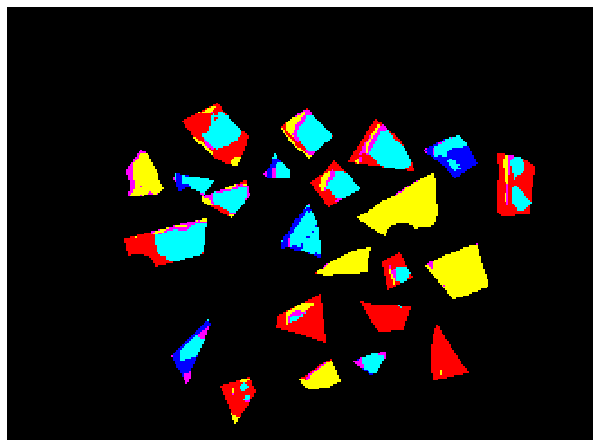

<Figure size 864x576 with 0 Axes>

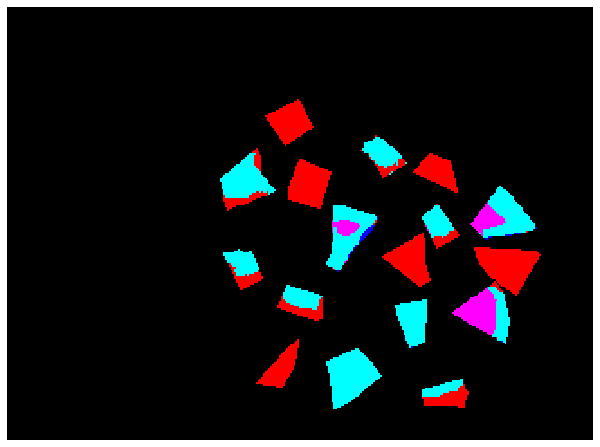

<Figure size 864x576 with 0 Axes>

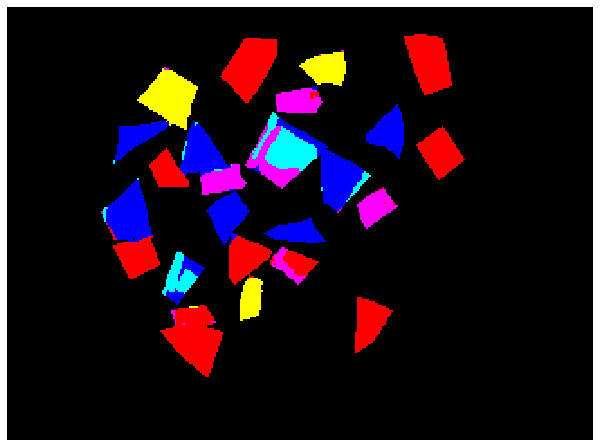

<Figure size 864x576 with 0 Axes>

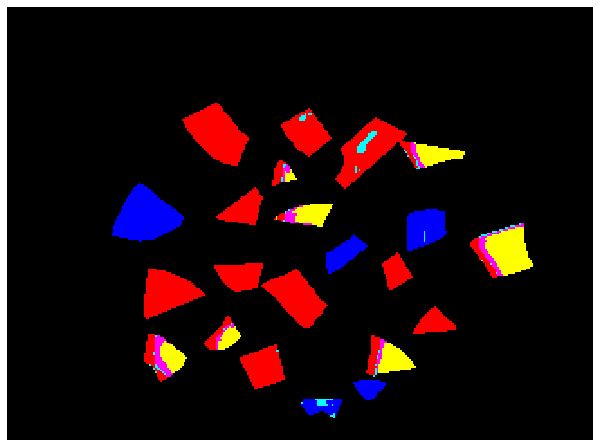

In [12]:
# MFT Pixel-wise Classification Results Visualization

import matplotlib.pyplot as plt
pred_y2 = pred_y.cpu().numpy()

prediction_masks = reconstruct_predictions(test_GT, pred_y2)
figsize = (10.5,8)
visualize_mask(prediction_masks[test_indices.index(0)],figsize)
plt.figure(figsize=(12,8))
visualize_mask(prediction_masks[test_indices.index(46)],figsize)
plt.figure(figsize=(12,8))
visualize_mask(prediction_masks[test_indices.index(41)],figsize)
plt.figure(figsize=(12,8))
visualize_mask(prediction_masks[test_indices.index(5)],figsize)

In [13]:
# Majority voting from zero-shot segmentation masks

objects = []
for i in test_indices:
    objects.append(load_and_decompress("zero-shot/" + str(i) +".pkl"))
    
# Apply with debugging
majority_voted_masks = majority_voting_with_segmentation(prediction_masks, objects, area = 10)

# Visualization (assuming your visualize_mask function works)
test_indices = [0, 1, 4, 5, 6, 7, 8, 12, 41, 46, 50]
plt.figure(figsize=(12,8))
for idx in [0, 46, 41, 5]:
    plt.figure(figsize=(12,8))
    visualize_mask(majority_voted_masks[test_indices.index(idx)])
plt.show()

In [15]:
# MFT Object-wise Classification Numerical Evaluation

metrics = calculate_segmentation_metrics(test_GT, majority_voted_masks)
print(f"Average F1-score: {metrics['average_f1_score']:.4f}")
print(f"F1-scores per class: {[f'{score:.4f}' for score in metrics['f1_scores_per_class']]}")
print(f"Average Accuracy (AA): {metrics['average_accuracy']:.4f}")
print(f"Pixel Accuracy (OA): {metrics['pixel_accuracy']:.4f}")


Average F1-score: 0.7453
F1-scores per class: ['0.9993', '0.8265', '0.8035', '0.7019', '0.3954']
Average Accuracy (AA): 0.7455
Pixel Accuracy (OA): 0.9816
